In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf

In [3]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [4]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [5]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [6]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [7]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [8]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [9]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [10]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 4s 7ms/sample - loss: 0.1322 - val_loss: 0.0449
Epoch 2/80
624/624 [==============================] - 0s 624us/sample - loss: 0.0116 - val_loss: 0.0421
Epoch 3/80
624/624 [==============================] - 0s 619us/sample - loss: 0.0113 - val_loss: 0.0730
Epoch 4/80
624/624 [==============================] - 0s 618us/sample - loss: 0.0075 - val_loss: 0.0183
Epoch 5/80
624/624 [==============================] - 0s 617us/sample - loss: 0.0066 - val_loss: 0.0198
Epoch 6/80
624/624 [==============================] - 0s 614us/sample - loss: 0.0071 - val_loss: 0.0208
Epoch 7/80
624/624 [==============================] - 0s 624us/sample - loss: 0.0059 - val_loss: 0.0270
Epoch 8/80
624/624 [==============================] - 0s 621us/sample - loss: 0.0063 - val_loss: 0.0305
Epoch 9/80
624/624 [==============================] - 0s 693us/sample - loss: 0.0058 - val_loss: 0.0294
Epoch 10/80
624/624 

624/624 [==============================] - 0s 709us/sample - loss: 0.0059 - val_loss: 0.0274
Epoch 79/80
624/624 [==============================] - 0s 651us/sample - loss: 0.0054 - val_loss: 0.0210
Epoch 80/80
624/624 [==============================] - 0s 650us/sample - loss: 0.0061 - val_loss: 0.0171


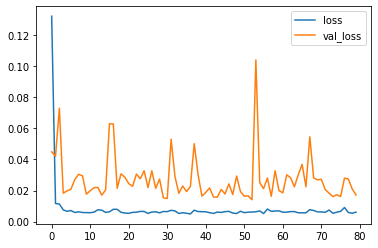

In [11]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


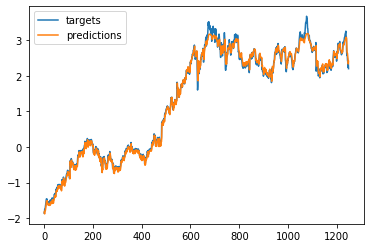

In [12]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

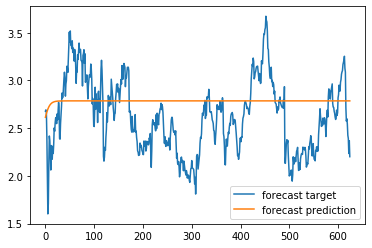

In [13]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [14]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [15]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [16]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [17]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


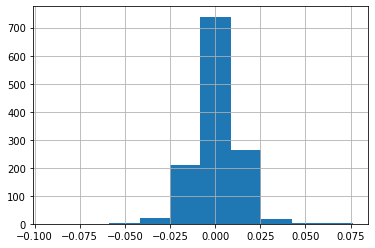

In [18]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [19]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [20]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [21]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 624 samples, validate on 624 samples
Epoch 1/80
624/624 [==============================] - 4s 6ms/sample - loss: 0.9919 - val_loss: 1.1607
Epoch 2/80
624/624 [==============================] - 0s 638us/sample - loss: 0.9855 - val_loss: 1.1456
Epoch 3/80
624/624 [==============================] - 0s 629us/sample - loss: 0.9864 - val_loss: 1.1387
Epoch 4/80
624/624 [==============================] - 0s 626us/sample - loss: 0.9845 - val_loss: 1.1582
Epoch 5/80
624/624 [==============================] - 0s 637us/sample - loss: 0.9875 - val_loss: 1.1449
Epoch 6/80
624/624 [==============================] - 0s 637us/sample - loss: 0.9828 - val_loss: 1.1460
Epoch 7/80
624/624 [==============================] - 0s 629us/sample - loss: 0.9819 - val_loss: 1.1467
Epoch 8/80
624/624 [==============================] - 0s 631us/sample - loss: 0.9833 - val_loss: 1.1541
Epoch 9/80
624/624 [==============================] - 0s 646us/sample - loss: 0.9834 - val_loss: 1.1473
Epoch 10/80
624/624 

624/624 [==============================] - 0s 650us/sample - loss: 0.7792 - val_loss: 1.3210
Epoch 79/80
624/624 [==============================] - 0s 625us/sample - loss: 0.7819 - val_loss: 1.3640
Epoch 80/80
624/624 [==============================] - 0s 650us/sample - loss: 0.8000 - val_loss: 1.3406


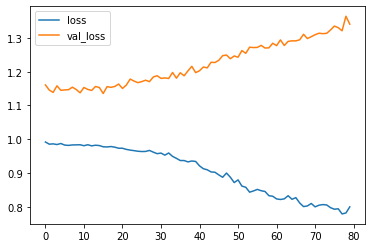

In [22]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


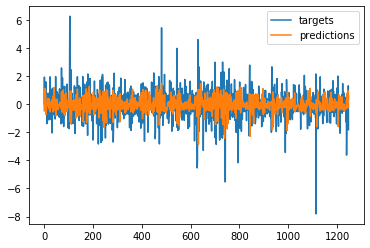

In [23]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

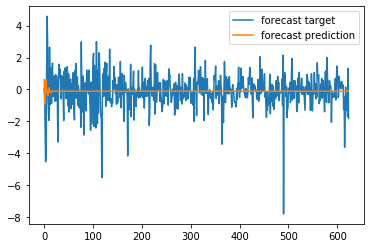

In [24]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [25]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [26]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [27]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [28]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [29]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [30]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [31]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Train on 839 samples, validate on 410 samples
Epoch 1/300
839/839 [==============================] - 5s 6ms/sample - loss: 0.6949 - accuracy: 0.5149 - val_loss: 0.6973 - val_accuracy: 0.4707
Epoch 2/300
839/839 [==============================] - 1s 784us/sample - loss: 0.6923 - accuracy: 0.5197 - val_loss: 0.6943 - val_accuracy: 0.4976
Epoch 3/300
839/839 [==============================] - 1s 775us/sample - loss: 0.6933 - accuracy: 0.5411 - val_loss: 0.6947 - val_accuracy: 0.4829
Epoch 4/300
839/839 [==============================] - 1s 791us/sample - loss: 0.6931 - accuracy: 0.5244 - val_loss: 0.6939 - val_accuracy: 0.5073
Epoch 5/300
839/839 [==============================] - 1s 807us/sample - loss: 0.6910 - accuracy: 0.5292 - val_loss: 0.6961 - val_accuracy: 0.4902
Epoch 6/300
839/839 [==============================] - 1s 790us/sample - loss: 0.6909 - accuracy: 0.5161 - val_loss: 0.6919 - val_accuracy: 0.5268
Epoch 7/300
839/839 [==============================] - 1s 825us/sample - l

839/839 [==============================] - 1s 855us/sample - loss: 0.6658 - accuracy: 0.5852 - val_loss: 0.7014 - val_accuracy: 0.5146
Epoch 57/300
839/839 [==============================] - 1s 899us/sample - loss: 0.6647 - accuracy: 0.5828 - val_loss: 0.7054 - val_accuracy: 0.5049
Epoch 58/300
839/839 [==============================] - 1s 886us/sample - loss: 0.6639 - accuracy: 0.5876 - val_loss: 0.7039 - val_accuracy: 0.5073
Epoch 59/300
839/839 [==============================] - 1s 914us/sample - loss: 0.6634 - accuracy: 0.5876 - val_loss: 0.7054 - val_accuracy: 0.5000
Epoch 60/300
839/839 [==============================] - 1s 1ms/sample - loss: 0.6635 - accuracy: 0.5864 - val_loss: 0.7071 - val_accuracy: 0.5024
Epoch 61/300
839/839 [==============================] - 1s 1ms/sample - loss: 0.6626 - accuracy: 0.5912 - val_loss: 0.7067 - val_accuracy: 0.5049
Epoch 62/300
839/839 [==============================] - 1s 1ms/sample - loss: 0.6586 - accuracy: 0.5864 - val_loss: 0.6994 - val_

839/839 [==============================] - 1s 865us/sample - loss: 0.5702 - accuracy: 0.6770 - val_loss: 0.7780 - val_accuracy: 0.4756
Epoch 112/300
839/839 [==============================] - 1s 977us/sample - loss: 0.5630 - accuracy: 0.6758 - val_loss: 0.7793 - val_accuracy: 0.4829
Epoch 113/300
839/839 [==============================] - 1s 1ms/sample - loss: 0.5556 - accuracy: 0.7032 - val_loss: 0.7766 - val_accuracy: 0.5000
Epoch 114/300
839/839 [==============================] - 1s 987us/sample - loss: 0.5570 - accuracy: 0.6996 - val_loss: 0.7843 - val_accuracy: 0.4805
Epoch 115/300
839/839 [==============================] - 1s 891us/sample - loss: 0.5555 - accuracy: 0.6782 - val_loss: 0.7808 - val_accuracy: 0.4780
Epoch 116/300
839/839 [==============================] - 1s 871us/sample - loss: 0.5520 - accuracy: 0.7092 - val_loss: 0.7887 - val_accuracy: 0.4854
Epoch 117/300
839/839 [==============================] - 1s 880us/sample - loss: 0.5479 - accuracy: 0.6901 - val_loss: 0.7

839/839 [==============================] - 1s 883us/sample - loss: 0.4217 - accuracy: 0.7688 - val_loss: 0.8942 - val_accuracy: 0.5122
Epoch 167/300
839/839 [==============================] - 1s 895us/sample - loss: 0.4207 - accuracy: 0.7783 - val_loss: 0.8605 - val_accuracy: 0.5146
Epoch 168/300
839/839 [==============================] - 1s 855us/sample - loss: 0.4113 - accuracy: 0.7831 - val_loss: 0.8676 - val_accuracy: 0.5098
Epoch 169/300
839/839 [==============================] - 1s 853us/sample - loss: 0.4098 - accuracy: 0.7902 - val_loss: 0.8801 - val_accuracy: 0.5220
Epoch 170/300
839/839 [==============================] - 1s 859us/sample - loss: 0.4019 - accuracy: 0.7914 - val_loss: 0.8859 - val_accuracy: 0.5073
Epoch 171/300
839/839 [==============================] - 1s 837us/sample - loss: 0.3991 - accuracy: 0.7962 - val_loss: 0.8720 - val_accuracy: 0.5122
Epoch 172/300
839/839 [==============================] - 1s 870us/sample - loss: 0.3946 - accuracy: 0.8033 - val_loss: 0

839/839 [==============================] - 1s 836us/sample - loss: 0.2929 - accuracy: 0.8498 - val_loss: 1.0808 - val_accuracy: 0.5146
Epoch 222/300
839/839 [==============================] - 1s 831us/sample - loss: 0.2890 - accuracy: 0.8617 - val_loss: 1.0505 - val_accuracy: 0.5171
Epoch 223/300
839/839 [==============================] - 1s 854us/sample - loss: 0.2923 - accuracy: 0.8546 - val_loss: 1.0351 - val_accuracy: 0.5341
Epoch 224/300
839/839 [==============================] - 1s 860us/sample - loss: 0.3020 - accuracy: 0.8510 - val_loss: 1.0816 - val_accuracy: 0.5098
Epoch 225/300
839/839 [==============================] - 1s 876us/sample - loss: 0.2897 - accuracy: 0.8546 - val_loss: 1.0752 - val_accuracy: 0.5146
Epoch 226/300
839/839 [==============================] - 1s 893us/sample - loss: 0.2827 - accuracy: 0.8605 - val_loss: 1.0767 - val_accuracy: 0.5000
Epoch 227/300
839/839 [==============================] - 1s 863us/sample - loss: 0.2885 - accuracy: 0.8617 - val_loss: 1

839/839 [==============================] - 1s 838us/sample - loss: 0.2151 - accuracy: 0.8963 - val_loss: 1.2520 - val_accuracy: 0.5122
Epoch 277/300
839/839 [==============================] - 1s 834us/sample - loss: 0.1996 - accuracy: 0.9154 - val_loss: 1.2525 - val_accuracy: 0.5195
Epoch 278/300
839/839 [==============================] - 1s 834us/sample - loss: 0.2208 - accuracy: 0.8975 - val_loss: 1.2449 - val_accuracy: 0.5293
Epoch 279/300
839/839 [==============================] - 1s 833us/sample - loss: 0.2130 - accuracy: 0.8999 - val_loss: 1.2759 - val_accuracy: 0.5098
Epoch 280/300
839/839 [==============================] - 1s 850us/sample - loss: 0.2044 - accuracy: 0.9094 - val_loss: 1.2758 - val_accuracy: 0.5195
Epoch 281/300
839/839 [==============================] - 1s 856us/sample - loss: 0.1913 - accuracy: 0.9154 - val_loss: 1.2633 - val_accuracy: 0.5171
Epoch 282/300
839/839 [==============================] - 1s 808us/sample - loss: 0.1860 - accuracy: 0.9249 - val_loss: 1

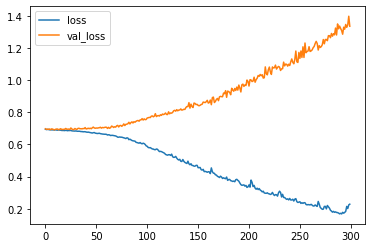

In [32]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

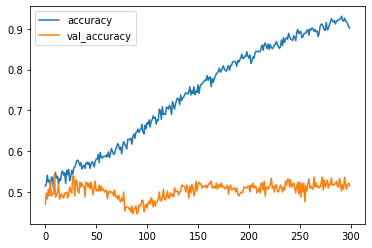

In [33]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()